# Brief Summary of Fourier Methods for Image Processing

Yada yada yada Ryan for the love of god just copy your notes into here


## Now we move on to the actual tutorial

To anyone reading this section, this tutorial works. Just doesn't have a lot of polish on it yet lol.

1) ~~Imports and backend configuration~~

2) Numpy example (easy on the cpu stuff) --> have this written on laptop or in imagepypelines image plugin

3) PyTorch example (~~with GPU~~ and without GPU using context environment, stacks of images too!!!)

4) CuPy example? Not super necessary, but it'd be nice to show people lower level options

5) Numba+CUDA example? Again, not super necessary, but ^^^

6) Real-world examples (maybe intro into physical optics or feature analysis? could be fun little addition)

7) Benchmarking --> super low hanging fruit, just need to do it!!!

8) ~~Get running on Colab~~

9) Clean up kernel and normalize everything so it just looks nicer. Maybe do a plot of source, filter, and output in space and in frequency for illustrative purposes

10) Port helper functions to regular ol' python library


## Try this notebook using Google Colab!

This can be useful if you'd like to avoid setting up the dependencies mentioned in the README on your own machine, and is a free service. Be sure to select a runtime with GPU acceleration!

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/RyanHartzell/cudnn-image-filtering/blob/master/notebooks/CuDNN%20Image%20Filtering%20Tutorial%20Using%20PyTorch.ipynb)

## Let's start with some imports

In [29]:
# Import necessary libraries and setup default configurations
import numpy as np

import matplotlib.pyplot as plt

from skimage import io
import torch
import torch.nn.functional as F
%matplotlib inline
# Make sure backend behaves deterministically for reproducability
torch.backends.cudnn.deterministic = False

## Next, we'll read in some image data

We'll be using lenna.tif if you have relative access to the 'images' directory of this project, and using an imageio-native test image if running on either your own machine or on Google Colab.

In [30]:
# Set up Lena.tif input - DO NOT RUN THIS CELL IF USING GOOGLE COLAB!!!
#src = imageio.imread("4780_input.png").astype(np.float32)

In [31]:
# Set up camera.png input - SAFE FOR GOOGLE COLAB
src = io.imread("4780_input.png")

In [80]:
from skimage import img_as_float32
src = img_as_float32(src)
src.max()

1.0

In [82]:
src.dtype

dtype('float32')

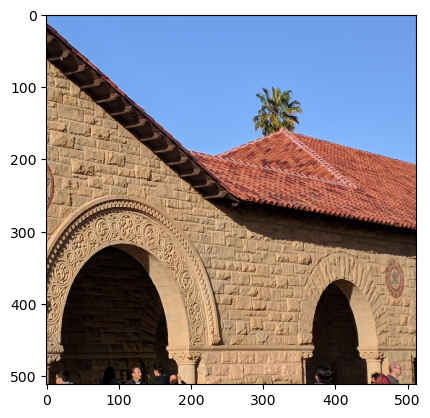

In [83]:
# Show the source image
#fig = plt.figure()
plt.imshow(src)
plt.show()

## Here we set up our filter, known as a "kernel"

In [86]:
# Set up filter kernel of shape 5x5 (And yes, this is in fact an incredibly wonky kernel just for fun lol)
kernel = np.asarray([[  1,    1,   25,    1,    1],
                     [  1,   50,   10,   50,    1],
                     [ 25,   10,    1,   10,   25],
                     [  1,   50,   10,   50,    1],
                     [  1,    1,   25,    1,    1]], dtype=np.float32)


## Next we've got a basic filtering example set up using Numpy

In [87]:
# Coming soon to a jupyter notebook near you...

In [88]:
filter_tensor.dtype

torch.float32

## And now we've got a GPU accelerated example using PyTorch

The following cells will show how to use PyTorch along with CUDA and CuDNN (a CUDA library for optimizing deep neural network performance in both training and inference, since it's all just filtering) for image filtering tasks.

Shape of Source tensor is:   torch.Size([1, 512, 512, 3])
Shape of Filter tensor is:   torch.Size([1, 3, 5, 5])
Shape of Output tensor is:   torch.Size([1, 1, 512, 512])    Notice we lost 2 pixels on either side since we didn't pad!


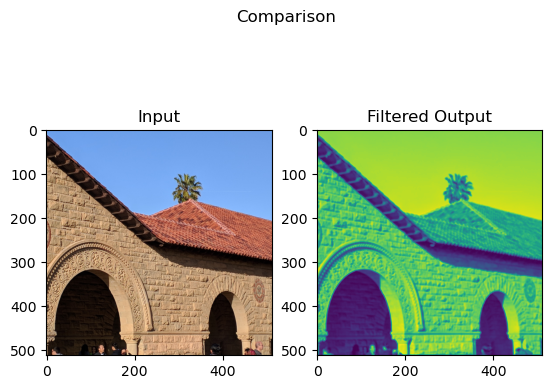

In [94]:
# convert to tensor of shape: [sample_size, channels, height, width]
source_tensor = torch.from_numpy(src)
source_tensor.unsqueeze_(0)   # adds dimensions of samplesize and channels or depth (for single image case)
print("Shape of Source tensor is:  ", source_tensor.size())
source_tensor = source_tensor.permute(0, 3, 1, 2)
filter_tensor = torch.from_numpy(kernel)
filter_tensor.unsqueeze_(0).unsqueeze_(0) # adds dimensions of samplesize and channels or depth (for single image case)
filter_tensor = torch.concatenate((filter_tensor, filter_tensor, filter_tensor), axis=1)
print("Shape of Filter tensor is:  ", filter_tensor.size())

# perform filtering
output_tensor = F.conv2d(source_tensor, filter_tensor, padding=2).to("cpu")   # without the '.to("cpu")' results would be on gpu
print("Shape of Output tensor is:  ", output_tensor.size(), "   Notice we lost 2 pixels on either side since we didn't pad!")

# print(src_tensor.device)
# print(filter_tensor.device)
# print(output_tensor.device)

output = np.asarray(output_tensor)[0,0,:,:]   # For now we just want the [H,W] image representation
# print(output)

# plot result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison')
ax1.set_title("Input")
ax1.imshow(src)
ax2.set_title("Filtered Output")
ax2.imshow(output)
plt.show()

## With the basics done, let's collect some timing benchmarks

C:\Users\abdu_\anaconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1, 3, 512, 512])) that is different to the input size (torch.Size([1, 1, 512, 512])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [1/500], Loss: 329310.90625
Epoch [51/500], Loss: 306548.15625
Epoch [101/500], Loss: 284944.40625
Epoch [151/500], Loss: 264502.65625
Epoch [201/500], Loss: 245182.140625
Epoch [251/500], Loss: 226941.75
Epoch [301/500], Loss: 209741.578125
Epoch [351/500], Loss: 193542.703125
Epoch [401/500], Loss: 178306.515625
Epoch [451/500], Loss: 163995.140625
Epoch [500/500], Loss: 150831.328125
Learned Filter Shape: (5, 5)


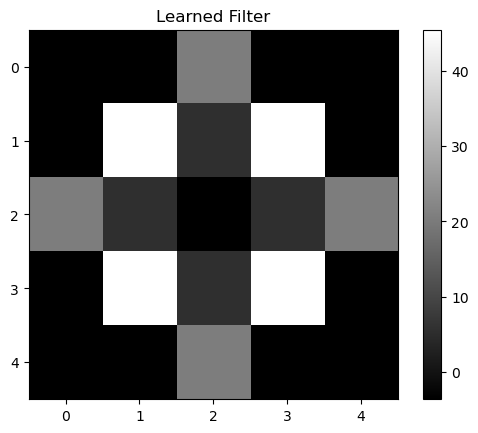

In [109]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Example source and target images
source_tensor = img_as_float32(io.imread("4780_input.png"))
target_tensor = img_as_float32(io.imread("4780_target.png"))


# convert to tensor of shape: [sample_size, channels, height, width]
source_tensor = torch.from_numpy(src)
source_tensor.unsqueeze_(0)   # adds dimensions of samplesize and channels or depth (for single image case)
source_tensor = source_tensor.permute(0, 3, 1, 2)


# convert to tensor of shape: [sample_size, channels, height, width]
target_tensor = torch.from_numpy(target_tensor)
target_tensor.unsqueeze_(0)   # adds dimensions of samplesize and channels or depth (for single image case)
target_tensor = target_tensor.permute(0, 3, 1, 2)



# Initialize trainable filter
filter_tensor = torch.nn.Parameter(torch.randn(1, 1, 5, 5, requires_grad=True))  # Shape: (Out_channels, In_channels, Kernel_H, Kernel_W)
filter_tensor = torch.from_numpy(kernel)
filter_tensor.unsqueeze_(0).unsqueeze_(0) # adds dimensions of samplesize and channels or depth (for single image case)
filter_tensor = torch.concatenate((filter_tensor, filter_tensor, filter_tensor), axis=1)
filter_tensor.requires_grad = True

# Optimizer
optimizer = torch.optim.Adam([filter_tensor], lr=0.01)

# Loss function
loss_fn = nn.MSELoss()

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()  # Zero gradients
    
    # Perform convolution with padding
    output_tensor = F.conv2d(source_tensor, filter_tensor, padding=2)
    
    # Compute loss
    loss = loss_fn(output_tensor, target_tensor)
    
    # Backpropagation
    loss.backward()
    optimizer.step()
    
    # Print loss
    if epoch % 50 == 0 or epoch == epochs - 1:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item()}")

# View the learned filter
learned_filter = filter_tensor.detach().cpu().numpy()[0, 0]  # Extract filter weights
print("Learned Filter Shape:", learned_filter.shape)
plt.imshow(learned_filter, cmap='gray')
plt.title("Learned Filter")
plt.colorbar()
plt.show()

In [108]:
# perform filtering
with torch.no_grad():
    output_tensor = F.conv2d(source_tensor, filter_tensor, padding=2) # without the '.to("cpu")' results would be on gpu
    print("Shape of Output tensor is:  ", output_tensor.size(), "   Notice we lost 2 pixels on either side since we didn't pad!")

# print(src_tensor.device)
# print(filter_tensor.device)
# print(output_tensor.device)
output_tensor.squeeze_(0)
source_tensor.squeeze_(0)
output_tensor.permute(1,2,0)
source_tensor.permute(1,2,0)
output = np.asarray(output_tensor)
src = np.asarray(source_tensor)
# print(output)

# plot result
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Comparison')
ax1.set_title("Input")
ax1.imshow(src)
ax2.set_title("Filtered Output")
ax2.imshow(output)
plt.show()

Shape of Output tensor is:   torch.Size([1, 512, 512])    Notice we lost 2 pixels on either side since we didn't pad!


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3